# Data assimilation in MITgcm

In this tutorial, we follow a modified MITgcm tutorial, `verification/lab_sea`, in which a regional spherical-polar coordinate ocean model is constrained to synthetic sea-surface temperature (SST) data via the adjoint method through automatic differentiation.

## Goals
1. Understanding MITgcm data assimilation workflows
2. Gain physical intuition for what to expect when constraining a general circulation model to observational data, particularly with regards to model sensitivity to controls
3. Probe model output using python tools `xmitgcm` and `xarray`

```{tip}
A Jupyter Notebook, [labsea_assim_tutorial](../../../assets/lab_sea/labsea_assim_tutorial) (after downloading, rename it to `labsea_assim_tutorial.ipynb`), is provided for users' convenience. It reproduces the steps and figures described in this visualization tutorial. Users can also add more sophisticated analysis on top of this notebook. `code` and `input` used to configure the MITgcm simulation can be found [here](https://github.com/ECCO-Hackweek/ecco-2024/blob/main/assets/lab_sea/).
```


### The model
We use a regional domain encompassing the Labrador Sea within the bounding box given by $79^\circ $E, $41^\circ $E,  $47^\circ $N, and $77^\circ $N. The domain has horizontal size $(n_x, n_y) = (16, 20)$ with $2^\circ$ grid spacing in either horizontal direction. Unlike the verification exercises default configuration, we implement $n_z=21$ vertical levels. This tutorial takes advantage of the low number of spatial degrees of freedom combined with a short simulation time of 6 days to quickly demonstrate the key concepts to monitor when performing adjoint-based data assimilation. Higher resolution global ocean model adjoints are much more memory-intensive, but many of the same takeaways from this example will translate.

![alt text](labsea_bathy.png "Labrador Sea Bathymetry")

### Run the forward model
The regional model is initalized with bathymetry (pictured above), initial temperature $\theta_0$, initial salinity $S_0$, external forcings, and a number of model parameters specified in files like [data](../../../assets/lab_sea/input/data) within the `input` directory. The model has been compiled with MITgcm `checkpoint68i` code with specific modifications made in `code`. The code directory is set up to compile the adjoint executable, but if one is just interested in simply analyzing model diagnostics or computing a misfit (but not *reducing* it), they can exclude `adjoint` from `code/packages.conf`. 

Let's examine some forward model output produces in the 0th run directory `run/iter0000`. We use `xmitgcm.open_mdsdataset` to load diagnostic and model grid data.

### Load diagnostic data

In [85]:
import numpy as np
import xarray as xr
import xmitgcm
from xmitgcm.utils import *
import matplotlib.pyplot as plt
import subprocess
import glob
import warnings
warnings.filterwarnings('ignore')

In [86]:
root_dir = '/efs_ecco/mgoldber/MITgcm_c68i/verification/lab_sea/ecco_hackathon/'
run_dir = root_dir + 'run/'
run_dir0 = run_dir + 'iter0000/'

In [87]:
prefix = 'diags3d' # other available daily diagnostics found in this run:
                   # diags2D, diagsEXF, diagsSI, diagsKPP

ds = xmitgcm.open_mdsdataset(run_dir0,
                        grid_dir = run_dir0,
                        prefix = [prefix],
                        default_dtype=np.float32,
                        delta_t=900,
                        ref_date='1979-01-01 00:00:00'
                            )
ds['XC'] = xr.where(ds.XC > 180, ds.XC - 360, ds.XC)
ds['XG'] = xr.where(ds.XG > 180, ds.XG - 360, ds.XG)


### Look at model-data misfit
The observational data used in this experiment is comprised of a single SST field occuring in the sixth record of the file `labsea_SST_fields_linear_rec006`. Our specifications in `data.ecco` instruct the model to compute a misfit between the model SST and this dataset on the sixth day of the run. Let's add the dataset to our dataset.

In [88]:
nz, nx, ny = ds.hFacC.shape
nday = 6

In [89]:
data_sst = read_raw_data(run_dir0 + '/labsea_SST_fields_linear_rec006', dtype=np.dtype('>f8'), shape=(nday, nx, ny))
data_sst[data_sst==-9999] = np.nan
ds['data_sst'] = xr.DataArray(data_sst, dims=['time','YC','XC'])

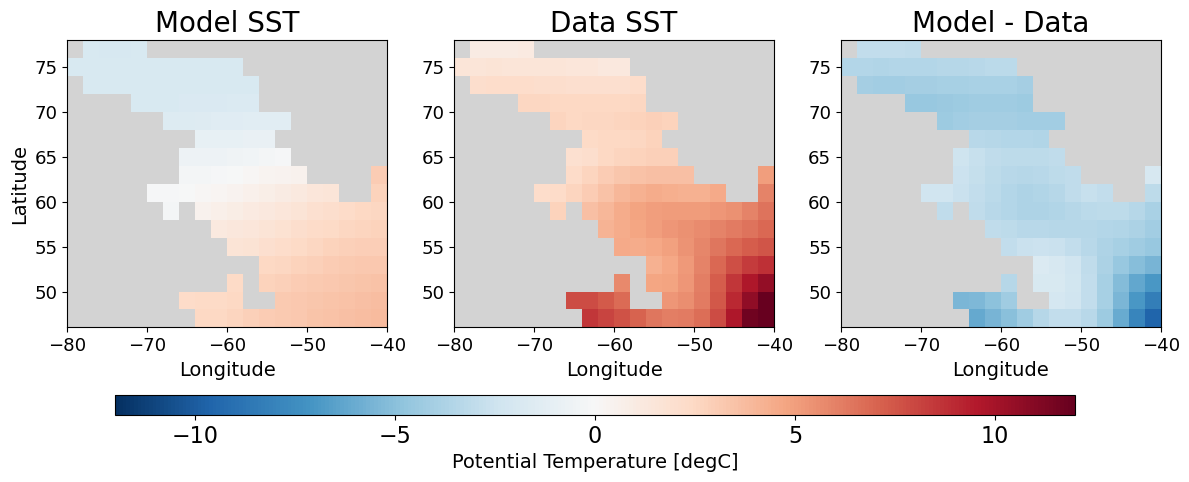

In [90]:
vmin, vmax = (-12, 12)
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad(color='#d3d3d3')

def plot_model_data_misfit(ds):
    
    fig, axes = plt.subplots(1, 3)
    (ax1, ax2, ax3) = axes

    model_sst = ds.THETA.isel(time=5, Z=0).where(ds.hFacC.isel(Z=0))
    p = model_sst.plot(ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax, extend='both', add_colorbar=False)
    ax1.set_title('Model SST', fontsize=20)
    ax1.set_ylabel('Latitude', fontsize=14)
    ax1.set_xlabel('Longitude', fontsize=14)
    
    
    data_sst = ds.data_sst.isel(time=5).where(ds.hFacC.isel(Z=0))
    p = data_sst.plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap, extend='both', add_colorbar=False)
    ax2.set_title('Data SST', fontsize=20)
    ax2.set_ylabel('')
    ax2.set_xlabel('Longitude', fontsize=14)
    
    misfit_sst_offline = (model_sst - data_sst)
    p = misfit_sst_offline.plot(ax=ax3, vmin=vmin, vmax=vmax, cmap=cmap, extend='both', add_colorbar=False)
    ax3.set_title('Model - Data', fontsize=20)
    ax3.set_xlabel('Longitude', fontsize=14)
    ax3.set_ylabel('')
    
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.05])  # Position [left, bottom, width, height]
    cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
    cbar_ax.tick_params(labelsize=16)
    cbar.ax.set_xlabel('Potential Temperature [degC]', fontsize=14)
    
    ax1.tick_params(axis='both', labelsize=13)
    ax2.tick_params(axis='both', labelsize=13)
    ax3.tick_params(axis='both', labelsize=13)
    
    fig.set_size_inches(12,4)
    fig.tight_layout()
    return fig, axes
fig, axes = plot_model_data_misfit(ds)
#fig.savefig('model_data_misfit_spatial.png', dpi=500, bbox_inches='tight', facecolor='white')

### Compute model-data misfit by hand
By the end of a forward run compiled with `pkg/ecco` and `pkg/cost`, a file `costfunctionXXXX` is created containing the scalar cost functional $J:\mathbb{R}^n\rightarrow\mathbb{R}$ given by
$
J({\bf u}) = \frac{1}{2}\left({\bf d} - \textbf{Obs}({\bf u})\right)^T{\bf R}^{-1}\left({\bf d} - \textbf{Obs}({\bf u})\right) 
+\frac{1}{2}({\bf u} - {\bf u}_0)^T{\bf B}^{-1}({\bf u} - {\bf u}_0).
$
In the first term, the misfit captures the discrepency between model and data, weighted by the our uncertainty in the observations. The second term acts as a numerical regularizer for the ill-posed inverse problem, penalizing deviations from the initial guess ${\bf u}_0$. The table below describes the terms of $J$, with notation taken from [Loose & Heimbach (2021)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002386).
| Variable                       | Description                                                                                                          |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------|
| $ J({\bf u}) $                | cost function, i.e. the scalar misfit between the model and observations                              |
| $ {\bf d} $                   | observational data vector                         |
| $ \textbf{Obs}({\bf u}) $     | observation operator giving the "model equivalent" to the data                                   |
| $ {\bf R} $                   | observational data error covariance matrix, representing the uncertainties in the observations $ {\bf d} $       |
| $ {\bf u} $                   | control variables, such as initial conditions, boundary conditions (e.g. atmospheric forcing or regional open boundaries), or model parameters |
| $ {\bf u}_0 $                 | prior estimate of the control variables, serving as a reference or initial guess                               |
| $ {\bf B} $                   | background error covariance matrix, representing uncertainties in the prior estimate $ {\bf u_0} $          |

We aim to constrain our model trajectory towards the data, thereby reducing the cost. Let's compute the misfit offline to confirm we have a full understanding of how the model is coming up with $J$.

In [91]:
## ONLINE
# grep the cost directly from costfunctionXXXX file
def grep_cost(run_dir, field_name='fc', ioptim=0):
    costfunction_filename = f'{run_dir}/costfunction{ioptim:04d}'    
    sysstr='grep ^{}.* {} | awk \'{{print $3}}\' |  sed \'s/D/E/g\''\
            .format(field_name, costfunction_filename)
    grepstr = subprocess.check_output(sysstr, shell=True)
    grepfloat = float(grepstr.decode().strip('\n'))
    return grepfloat
J_online = grep_cost(run_dir0, ioptim=0)

## OFFLINE
# SST weight: spatially uniform, values of 1.042 deg C
model_sst_day6 = ds.THETA.isel(time=5, Z=0).where(ds.hFacC.isel(Z=0))
data_sst_day6 = ds.data_sst.isel(time=5).where(ds.hFacC.isel(Z=0))

misfit_sst_weight = read_raw_data(run_dir0 + 'sigma_sst_p010402.bin', dtype=np.dtype('>f8'), shape=(nx, ny))
J_offline = (((model_sst_day6 - data_sst_day6) / misfit_sst_weight)**2).sum().values

print(
      f'online:  J_SST = {J_online:0.6e}\n'\
      f'offline: J_SST = {J_offline:0.6e}\n'
      f'relative error = {100 * abs(J_offline - J_online)/abs(J_online):f}%'
)

online:  J_SST = 2.122397e+07
offline: J_SST = 2.122426e+07
relative error = 0.001353%


### Run the adjoint code, look at gradients $\partial J/\partial\text{xx}$
We now run the adjoint model and produce *gradients* or *sensitivities*. Here, we compute gradients of $J$ with respect to controls ${\bf u}$. The MITgcm also gives users the ability to look at sensitivites of a number of diagnostics to said controls, but here we will restrict our focus to the cost.

In this run, we control the 3d initial temperature field, $\theta_0$, and the 2d time-varying air temperature, $\text{atemp}$. Let's form a hypothesis for what the gradients will look like: 
- $\partial J/\partial \theta_0$: Recall we found that the data was warmer than the model giving rise to a negative misfit. As such, we expect that an increase in the initial temperature $\theta_0$ should decrease the cost $J$, thus $\partial J/\partial T_0 < 0$.
- $\partial J/\partial \text{atemp}$: Similarly, an increase in air temperature raises sea surface temperature. Therefore we expect the same relationship for $\partial J/\partial \text{atemp}$, that an increase in $\text{atemp}$ will decrease the cost $J$, or $\partial J/\partial T_0 < 0$.

In this simple setup, we will see that we can confirm our hypotheses. In more complicated models, however, deeper knowledge of the model dynamics is critical towards understanding the more complex sensitivities.

In [ ]:
# load dJ/dtheta
ioptim = 0
adxx_theta = read_raw_data(run_dir0 + f'adxx_theta.{ioptim:010d}.data', dtype=np.dtype('>f8'), shape=(nz, nx, ny))
ds['adxx_theta'] = xr.DataArray(adxx_theta,
                                dims=ds['THETA'].isel(time=0).dims,
                                coords=ds['THETA'].isel(time=0).coords)
# plot dJ/dtheta
vmax = np.nanmax(abs(adxx_theta))
vmin = -vmax

fig, ax = plt.subplots()
p = ds.adxx_theta.where(ds.hFacC[0]).isel(Z=0).plot(\
                                         x="XC",y="YC",
                                         cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('[dJ/degC]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlabel('Longitude', fontsize=14)

ax.set_title(r'$\frac{\partial J}{\partial {\mathrm{SST}_0}}$', fontsize=30, pad = 20)
ax.tick_params(axis='both', labelsize=14)

fig.set_size_inches(6,5)
fig.tight_layout()
#fig.savefig('dJdSST.png', dpi=500, bbox_inches='tight', facecolor='white')


We can do the same for the 2D time-varying control $\mathrm{atemp}$. Below, we plot snapshots of the gradients at different time lags propagating backwards in time through the adjoint run.

In [ ]:
nrec = nday + 1 # using knowledge of the number of records in this file 
                # read_mds would be preferable here, but I don't think it
                # properly implements nrec

adxx_atemp = read_raw_data(run_dir0 + f'adxx_atemp.{ioptim:010d}.data', dtype=np.dtype('>f8'), shape=(nrec, nx, ny))
adxx_atemp[adxx_atemp == 0.] = np.nan

fig, axes = plt.subplots(2, 3)

set_cbar = True

for i, ax in enumerate(axes.ravel()):
    fld = adxx_atemp[::-1][i]  # time-reversed order, how the adjoint operates

    vmax = 1e3 if set_cbar else np.nanmax(abs(fld))
    vmin = -vmax

    # Add the field to the dataset for convenient lat/lon axis ticks on 2D plots
    ds['fld'] = xr.DataArray(fld, dims=ds['rA'].dims, coords=ds['rA'].coords)
    p = ds.fld.where(ds.hFacC[0]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)

    ax.set_title(r'$\frac{\partial J}{\partial {\mathrm{atemp}}}$' + f' (lag {i} day)', fontsize=16)

    ax.set_xlabel('Longitude' if i >= 3 else '', fontsize=14)
    ax.set_ylabel('Latitude' if i % 3 == 0 else '', fontsize=14)
    
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # Position [left, bottom, width, height]
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=16)
cbar.ax.set_xlabel('Sensitivity to air temperature [dJ/degK]', fontsize=14)

fig.set_size_inches(10, 7)
fig.tight_layout()

#fig.savefig('dJdatemp.png', dpi=500, bbox_inches='tight', facecolor='white') # Vectorized PDF



As expected, the sensitivities are all negative. We can use the gradients to minimize our cost function through gradient descent.

$\mathbf{u}^{(k)} - \alpha \nabla J(\mathbf{u}^{(k)})=:\mathbf{u}^{(k+1)}$

Any number of optimization libraries facilitate this step. We proceed using the library [optim_m1qn3](https://github.com/mjlosch/optim_m1qn3), which implements a limited memory quasi-Newton (L-BFGS) algorithm. Specifying the `doMainPack` option inside `data.ctrl`, we bundle up our gradient information into a binary file `ecco_ctrl_MIT_CE_000.opt0000`, hand it off to `optim_m1qn3`, and run the optimization, obtaining a ${\bf u}^{(k+1)}$ in the file `ecco_ctrl_MIT_CE_000.opt0001`, which we refer to as the first iteration *control adjustment*. When we run our model with these perturbed controls, we will find that the cost $J$ decreases.

There are various options available to the user when performing the optimization step specified in `data.optim` (see warning below). Of note, the user must indicate a desired cost reduction through e.g. the parameter `dfminFrac`. Typically, reductions of 2%-5% are attainable. Later on, we will plot the cost function reduction across 10 optimization iterations to see how well we did.

> :::{warning}
> Confusingly, `data.optim` is also an input file used by MITgcm to instruct the model what optimization iteration it is running, but this is different from the file named `data.optim` used by `optim_m1qn3`. Furthermore, both softwares use input files by the name of `data.ctrl`, but they serve completely different purposes.

### Examine control adjustments
Below we load the adjustment made to the initial temperature control $\theta_0$. We plot the top level of the 3D array, the initial SST adjustment. Additionally, we confirm our understanding that 
$$\theta_0^0 + \delta\theta_0^1 =: \theta_0^1$$
where the subscripts denote initial temperature and the superscripts denote optimization iteration. Unsurprisingly, the perturbation is all positive. This makes sense knowing that the model was initially cooler than the data. In other words, the new initial condition we use for the next run is a perturbed (*warmer*, specifically) value of the old initial condition that will lead the model SST to be more similar to the data on day 6.

In [ ]:
run_dir0 = f'{run_dir}/iter{0:04d}/'
run_dir1 = f'{run_dir}/iter{1:04d}/'

# load control adjustments
xx_theta = read_raw_data(run_dir1 + f'xx_theta.{1:010d}.data', dtype=np.dtype('>f8'), shape=(nz, nx, ny))
xx_atemp = read_raw_data(run_dir1 + f'xx_atemp.{1:010d}.data', dtype=np.dtype('>f8'), shape=(nrec, nx, ny))
xx_theta[xx_theta == 0.] = np.nan
xx_atemp[xx_atemp == 0.] = np.nan

# load initial theta
theta0_iter0 = read_raw_data(run_dir0 + f'T.{0:010d}.data', dtype=np.dtype('>f4'), shape=(nz, nx, ny))
theta0_iter0[theta0_iter0==0.] = np.nan
theta0_iter1 = read_raw_data(run_dir1 + f'T.{0:010d}.data', dtype=np.dtype('>f4'), shape=(nz, nx, ny))
theta0_iter1[theta0_iter1==0.] = np.nan

# slice out SST
SST0_iter0 = theta0_iter0[0, :, :]
SST0_iter1 = theta0_iter1[0, :, :]

# confirm that \theta_0 + \delta\theta = \theta_1
assert np.allclose(T0_iter0 + xx_theta, T0_iter1, atol=1e-8, equal_nan=True)

In [ ]:
fig, ax = plt.subplots()
ds['xx_sst'] = xr.DataArray(xx_theta[0], dims=ds['rA'].dims, coords=ds['rA'].coords)

p = ds.xx_sst.where(ds.hFacC[0]).plot(vmin = -.3, vmax = .3, cmap=cmap, add_colorbar=False)
ax.set_title(r'$\delta\mathrm{SST}_0$', fontsize=30, pad=20)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlabel('Longitude', fontsize=14)

cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Potential Temperature [degC]', fontsize=14)
ax.tick_params(axis='both', labelsize=14)

fig.set_size_inches(6, 5)
fig.tight_layout()

# fig.savefig('delta_sst.png', dpi=500, bbox_inches='tight', facecolor='white') # Vectorized PDF

We can repeat the process for the perturbations made to $\mathrm{atemp}$. We find once again that the perturbations are all positive.

In [ ]:
fig, axes = plt.subplots(2, 3)
set_cbar = True
for i, ax in enumerate(axes.ravel()):
    fld = xx_atemp[::-1][i]

    vmax = 2e-2 if set_cbar else np.nanmax(abs(fld))
    vmin = -vmax

    # Add the field to the dataset for convenient lat/lon axis ticks on 2D plots
    ds['fld'] = xr.DataArray(fld, dims=ds['rA'].dims, coords=ds['rA'].coords)
    p = ds.fld.where(ds.hFacC[0]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)

    ax.set_title(r'$\delta\mathrm{atemp}$' + ' (lag {} day)'.format(i), fontsize=16)

    ax.set_xlabel('Longitude' if i >= 3 else '', fontsize=14)
    ax.set_ylabel('Latitude' if i % 3 == 0 else '', fontsize=14)
    
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # Position [left, bottom, width, height]
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=16)
cbar.ax.set_xlabel('Air temperature [degK]', fontsize=14)

fig.set_size_inches(10, 7)
fig.tight_layout()

#fig.savefig('dJdatemp.png', dpi=500, bbox_inches='tight', facecolor='white') # Vectorized PDF



### Load diagnostic data for many optimization iterations
At this point, one runs the model from the newly obtained control perturbations. We copy `ecco_ctrl_MIT_CE_000.opt0001` into the next run directory, `run/iter0001`, and read them into the model by setting `doMainUnpack` in `data.ctrl`. Running the model forward again, one may choose to compare the diagnostics generated by `iter0000` with those from `iter0001`. The user should also confirm that the total cost in `costfunction0001` is smaller  than that of `costfunction0000`. The optimization routine is repeated until the cost has been reduced by a desired amount. We have performed 10 optimization iterations and saved the diagnostics for each.

To assess our assimilation experiment, we create a wrapper to `xmitgcm.open_mdsdataset` to concatenate diagnostic datasets from multiple optimization iterations along a new axis `ioptim`. Note that this function is not particularly robust, in that we use knowledge of the directory structure:

```
run/
│
└───iter0000/
│   │   ...
│   
└───iter0001/
│   │   ...
│
│   ...
│ 
└───iter0009/
    │   ...
```

In [92]:
def open_mdsdataset_optim(run_dir,
                          nopts_max = None,
                          iter_dir_pfx = 'iter',
                          verbose=False,
                          **open_mdsdataset_kwargs):
    iter_dirs = np.sort(glob.glob(run_dir + iter_dir_pfx + '*/')).tolist()
    iter_dirs = iter_dirs[:nopts_max]

    ds_list = []
    for this_iter_dir in iter_dirs:
        if verbose: print(f'loading data from iter_dir={this_iter_dir}')
        ds_i = xmitgcm.open_mdsdataset(this_iter_dir,
                                       grid_dir = this_iter_dir,
                                       **open_mdsdataset_kwargs)
        ds_list.append(ds_i)
        ds_i.close()
    return xr.concat(ds_list, dim='ioptim')

prefix = 'diags3d'

ds = open_mdsdataset_optim(run_dir,
                        prefix = [prefix],
                        default_dtype=np.float32,
                        delta_t=900,
                        ref_date='1979-01-01 00:00:00'
                            )
ds['XC'] = xr.where(ds.XC > 180, ds.XC - 360, ds.XC)
ds['XG'] = xr.where(ds.XG > 180, ds.XG - 360, ds.XG)

nopts = len(ds.ioptim)
print(f'diagnostics from {nopts} optimization iterations loaded')

diagnostics from 10 optimization iterations loaded


### Plot the cost function reduction
We find that from optimization iteration one to two, a considerable decrease in the cost $J$ is achieved. After a few more iterations, the cost plateaus. The cost reduction is an indicator of a successful assimilation.

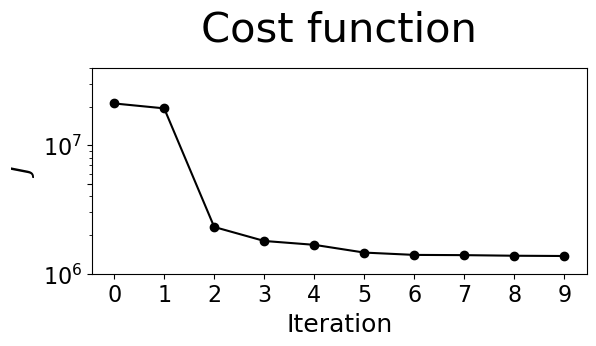

In [93]:
costs = []
for ioptim in range(nopts):
    run_dir_i = f'{run_dir}/iter{ioptim:04d}'
    costfunction_filename = f'{run_dir_i}/costfunction{ioptim:04d}'
    field_name = 'fc'
    costs.append(grep_cost(run_dir_i, ioptim=ioptim))

fig, ax = plt.subplots()
x = np.arange(nopts)
ax.plot(x, costs, 'k')#, alpha=.5)
ax.scatter(x, costs, c='k')#, alpha=.5)
ax.set_title(r'Cost function', fontsize=30, pad=20)
ax.set_ylabel(r'$J$', fontsize=18)
ax.set_xlabel('Iteration', fontsize=18)
ax.semilogy()
yticks = [1e7, 5e6, 1e6, 5e5]
ax.set_yticks(yticks)
ax.set_xticks(np.arange(nopts))
ax.set_ylim(1e6, 4e7)
ax.tick_params(axis='both', labelsize=16)
fig.tight_layout()
fig.set_size_inches(6, 3)

### Visualize the misfit reduction
Lastly, we can give a qualitative "eye test" to assure that the assimilation did what we expected by looking at the model SST on day 6 before and after optimization.

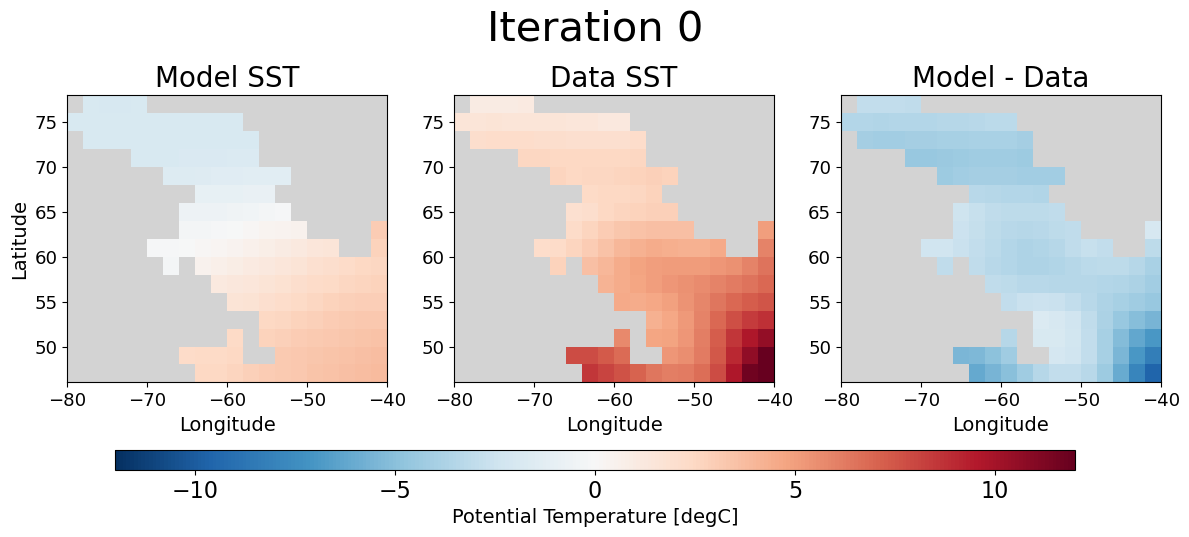

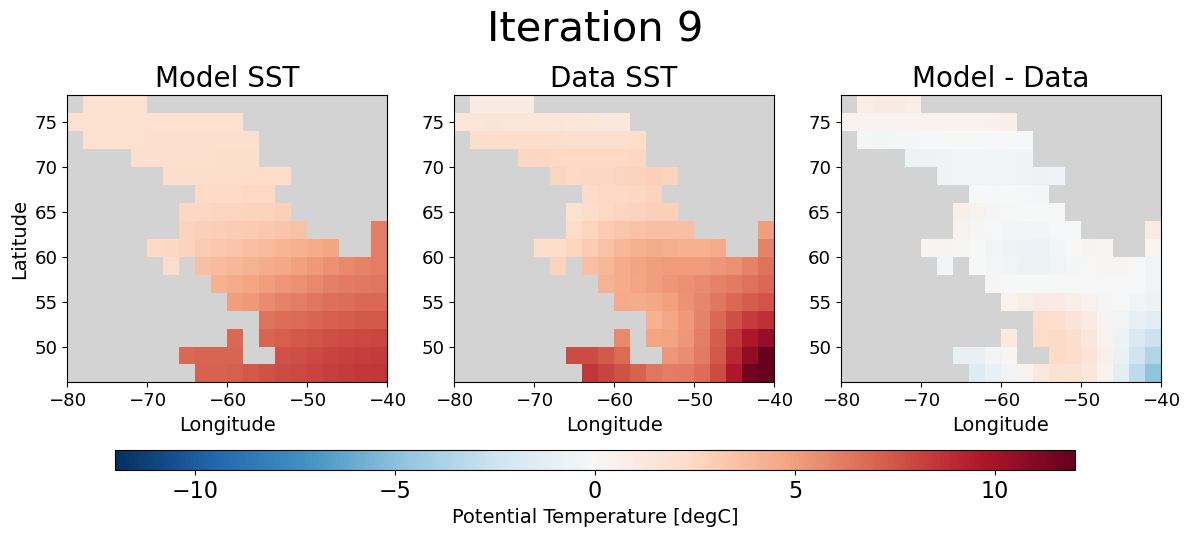

In [95]:
# re-add the observational data to the dataset
ds['data_sst'] = xr.DataArray(data_sst, dims=['time','YC','XC'])

fig, ax = plot_model_data_misfit(ds.isel(ioptim=0))
fig.suptitle('Iteration 0', fontsize=30, y = 1.1)

fig, ax = plot_model_data_misfit(ds.isel(ioptim=9))
fig.suptitle('Iteration 9', fontsize=30, y = 1.1);

Eureka💡! As we had hoped the model SST on day 6 looks much more similar to the observational data after optimization. Moreover, the spatial plot of the misfit is clearly nearer to zero almost everywhere. 

### Conclusion
We demonstrated the workflows used to assimilate synthetic observational data into an unconstrained MITgcm model. Along the way, we investigated model diagnostics, sensitivity to controls, control perturbations, and cost function reduction across iterations. The reader is encouraged to play with different model parameters in `data`, explore other options for $J$ such as boxmean quantities of interest ([more info here](https://mitgcm.readthedocs.io/en/latest/ocean_state_est/ocean_state_est.html)), and further probe changes in model diagnostics between iteration 0 and 9 to understand exacly how the physics of the model changed in order to accomodate the data.

### References
Adcroft, A., Campin, J., Dutkiewicz, S., Evangelinos, C., Ferreira, D., Forget, G., et al. (2018). MITgcm User Manual. Zenodo. https://doi.org/10.5281/zenodo.3248738

Loose, N., & Heimbach, P. (2021). Leveraging Uncertainty Quantification to Design Ocean Climate Observing Systems. *Journal of Advances in Modeling Earth Systems*, 13(4), e2020MS002386. https://doi.org/10.1029/2020MS002386
